In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import pandas as pd

import time
import os
import PIL.Image as Image
from IPython.display import display

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Load the data and transform

First, lets create some transforms for our data and load the train/test data+labels from the folders.

Here we are using 300x300 images with random horizontal flip, random rotation and normalization

In [2]:
dataset_dir = "../input/car_data/car_data/"

train_transform = transforms.Compose([transforms.Resize((300, 300)),
                                 transforms.RandomRotation(15),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
test_transform = transforms.Compose([transforms.Resize((300, 300)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = train_transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = 32, shuffle=True, num_workers = 2)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_transform)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = 32, shuffle=False, num_workers = 2)


## Model training function

Here we train our model, after each epoch, we test the model on the test data to see how it's going

In [6]:
def train_model(model, criterion, optimizer, scheduler, n_epochs = 5):
    
    losses = []
    accuracies = []
    
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        counter = 0
        for i, data in enumerate(trainloader, 0):
            
            inputs, labels = data
            
            # Assign data to CUDA if available
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            counter += len(inputs)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels) # We need to give the original propabilities instead of the final labels.
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss / counter
        print(running_correct, counter)
        epoch_acc = 100 * (running_correct / counter)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        scheduler.step(epoch_acc)
        since = time.time()
    print('Finished Training')
    
    return model, losses, accuracies

### Evaluate on testing data
This function is called out after training on the training data. We then measure the accuracy of the model.

In [4]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * (correct / total)
    print('Accuracy of the network on the test images: %d %%' % (
        test_acc))
    return test_acc

In [5]:
model_ft = models.resnet34(pretrained=True)

for param in model_ft.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features

# replace the last fc layer with an untrained one (requires grad by default)
model_ft.fc = nn.Linear(num_ftrs, 196)
model_ft = model_ft.to(device)


criterion = nn.CrossEntropyLoss()

paramsToUpdate = []
for name, param in model_ft.named_parameters():
    if (param.requires_grad == True):
        paramsToUpdate.append(param)

optimizer = optim.SGD(paramsToUpdate, lr=0.01, momentum=0.9)

lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
87306240it [00:01, 44190798.97it/s]


In [7]:
model_ft, training_losses, training_accs = train_model(model_ft, criterion, optimizer, lrscheduler, n_epochs=10)

385.0 8144
Epoch 1, duration: 112 s, loss: 0.1582, acc: 4.7274
1359.0 8144
Epoch 2, duration: 103 s, loss: 0.1255, acc: 16.6871
2119.0 8144
Epoch 3, duration: 102 s, loss: 0.1070, acc: 26.0192
2694.0 8144
Epoch 4, duration: 103 s, loss: 0.0947, acc: 33.0796
3118.0 8144
Epoch 5, duration: 103 s, loss: 0.0855, acc: 38.2859
3507.0 8144
Epoch 6, duration: 103 s, loss: 0.0784, acc: 43.0624
3711.0 8144
Epoch 7, duration: 103 s, loss: 0.0734, acc: 45.5673
3948.0 8144
Epoch 8, duration: 102 s, loss: 0.0688, acc: 48.4774
4912.0 8144
Epoch 9, duration: 102 s, loss: 0.0584, acc: 60.3143
4978.0 8144
Epoch 10, duration: 103 s, loss: 0.0572, acc: 61.1248
Finished Training


In [8]:
torch.save(model_ft.state_dict(), './restnet34FeatureExtraction') 

### As we can see the model reached 90% training accuracy by epoch 10.


In [9]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [10]:
eval_model(model_ft)

Accuracy of the network on the test images: 37 %


37.905733117771426

### View the missclassified Images

In [11]:
import pandas as pd

names = list(pd.read_csv("../input/names.csv", names = ['names'])['names'])

In [12]:
from matplotlib.pyplot import figure

def getMisclassifiedImages(model):
    count = 0
    with torch.no_grad():
        fig = figure(figsize=(10, 10))
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            for i in range(0, len(predicted)):
                if (predicted[i] != labels[i]):
                    img = images[i].cpu().numpy().transpose((1, 2, 0))
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    img = std * img + mean
                    plt.subplot(3, 2 , count + 1)
                    plt.tight_layout()
                    plt.title("Predicted : " + str(names[predicted[i]]) + "\n" + "Actual : " + str(names[labels[i]]) + "\n")
                    plt.imshow((img * 255).astype(np.uint8))
                    plt.axis("off")
                    count += 1
                    if (count == 6):
                        break
            if (count == 6):
                break

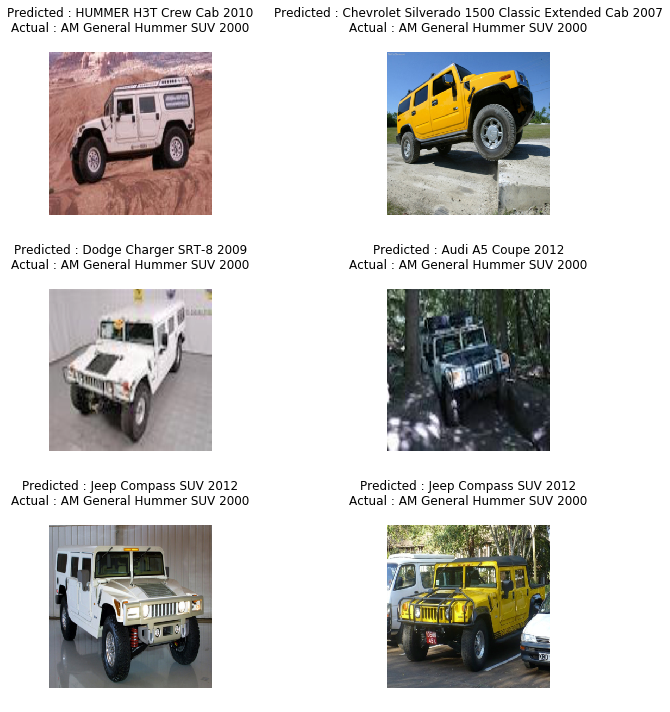

In [13]:
getMisclassifiedImages(model_ft)